In [ ]:
#default_exp data.datasets.business

# Business datasets

> API details.

In [ ]:
#export
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import s3fs
from dotenv import load_dotenv

from nixtla.data.datasets.utils import download_file, Info, TimeSeriesDataclass
from nixtla.data.tsdataset import TimeSeriesDataset

In [ ]:
#export
load_dotenv()

True

Business meta information

In [ ]:
#export
def remove_outliers(df: pd.DataFrame, seasonality: int) -> pd.DataFrame:
    """
    Removes outliers from data.
    """
    y = df['y'].values
    q1, q3 = np.quantile(y, [0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    idx_to_replace, = np.where((y > high) | (y < low))

    idx_replacements = idx_to_replace - seasonality

    repeated = np.isin(idx_replacements, idx_to_replace)
    repeated = idx_replacements[repeated]

    for idx in repeated:
        idx_replacements[idx_replacements == idx] = idx_replacements[idx_to_replace == idx]

    y[idx_to_replace] = y[idx_replacements]

    df['y'] = y

    return df


In [ ]:
#export
def cleanear_brc(ts: pd.DataFrame, seasonality: int) -> pd.DataFrame:
    """
    Cleans BRC dataset.
    """
    fix_dates = ['2018-11-19', '2018-12-25',
                 '2019-01-01', '2019-02-04', '2019-02-21',
                 '2019-03-18', '2019-04-19', '2019-05-01',
                 '2019-09-15', '2019-09-16', '2019-09-29',
                 '2019-10-06', '2019-11-17', '2019-12-01',
                 '2019-12-15', '2019-12-22', '2019-12-25',
                 '2019-12-28', '2019-12-29', '2020-01-01',
                 '2020-01-05', '2020-01-12', '2020-01-26',
                 '2020-02-02', '2020-02-03', '2020-02-09',
                 '2020-02-22', '2020-02-23']

    seasonal_fix_dates = pd.to_datetime(fix_dates) - pd.Timedelta(days=seasonality)
    seasonal_fix_dates = [date.strftime('%Y-%m-%d') for date in seasonal_fix_dates]

    to_fix = [date for date in seasonal_fix_dates if date in fix_dates]
    while to_fix:
        seasonal_fix_dates = [(pd.to_datetime(date) - pd.Timedelta(days=seasonality)).strftime('%Y-%m-%d') \
                              if date in to_fix else date \
                              for date in seasonal_fix_dates]
        to_fix = [date for date in seasonal_fix_dates if date in fix_dates]


    def get_updated_ts(fix_date, date):
        """
        fix_date: this date fixes date.
        date: date to fix.
        """
        fixed_date = ts.query('ds == @fix_date') \
                       .replace({fix_date: date})

        to_fix = ts.query('ds == @date')
        equal_order = np.array_equal(fixed_date['unique_id'].values,
                                     to_fix['unique_id'].values)

        assert equal_order

        fixed_date.index = to_fix.index

        return fixed_date

    fixed_dates = [get_updated_ts(fix_date, date) \
                   for fix_date, date in zip(seasonal_fix_dates, fix_dates)]
    fixed_dates = pd.concat(fixed_dates)
    ts.update(fixed_dates)

    ts = ts.groupby('unique_id') \
           .apply(remove_outliers, seasonality=7)

    ts['ds'] = pd.to_datetime(ts['ds'])
    ts = ts.query('ds >= "2018-05-02"').reset_index(drop=True)

    return ts

In [ ]:
#export
def cleanear_glb(ts: pd.DataFrame, seasonality: int) -> pd.DataFrame:
    """
    Cleans GLB dataset.
    """
    fix_dates = ['2019-04-30', '2019-05-01']
    seasonality = 7

    seasonal_fix_dates = pd.to_datetime(fix_dates) - pd.Timedelta(days=seasonality)
    seasonal_fix_dates = [date.strftime('%Y-%m-%d') for date in seasonal_fix_dates]

    fixed_dates = ts.query('ds in @seasonal_fix_dates') \
                    .replace(dict(zip(seasonal_fix_dates, fix_dates)))
    fixed_dates.index = ts.query('ds in @fix_dates').index

    ts.update(fixed_dates)

    ts = ts.groupby('unique_id') \
           .apply(remove_outliers, seasonality=7)

    ts['ds'] = pd.to_datetime(ts['ds'])
    ts = ts.query('ds >= "2018-04-01"').reset_index(drop=True)

    return ts

In [ ]:
#export
@dataclass
class BRC:
    seasonality: int = 7
    horizon: int = 7
    cleaner: Callable[[pd.DataFrame, int], pd.DataFrame] = cleanear_brc

In [ ]:
#export
@dataclass
class GLB:
    seasonality: int = 7
    horizon: int = 7
    cleaner: Callable[[pd.DataFrame, int], pd.DataFrame] = cleanear_glb

In [ ]:
#export
BusinessInfo = Info(groups=('BRC', 'GLB'),
                    class_groups=(BRC, GLB))

In [ ]:
#export
class Business:

    @staticmethod
    def load(directory: str,
             group: str,
             cache: bool = True):
        """
        Downloads and loads Tourism data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'GLB', 'BRC'.

        Notes
        -----
        [1] Returns train+test sets.
        """
        path = Path(directory) / 'business' / 'datasets'
        file_cache = path / f'ts-{group.lower()}.p'

        if file_cache.exists() and cache:
            df, X, S = pd.read_pickle(file_cache)

            return df, X, S

        Business.download(directory, group)

        class_group = BusinessInfo[group]

        df = pd.read_csv(path / f'ts-{group.lower()}.csv')
        df = class_group.cleaner(df, class_group.seasonality)
        
        if group == 'GLB':
            stat = pd.read_csv(path / f'ts-{group.lower()}-statics.csv')
            S = stat['unique_id'].drop_duplicates().to_frame()
            S = S.merge(stat, how='left', on=['unique_id'])
            
        else:
            S = None
        
        X = None

        if cache:
            data = (df, X, S)
            pd.to_pickle(data, file_cache)

        return df, X, S

    @staticmethod
    def download(directory: str, group: str) -> None:
        """Downloads Business Dataset."""

        fs = s3fs.S3FileSystem(key=os.environ['AWS_ACCES_KEY_ID'],
                               secret=os.environ['AWS_SECRET_ACCESS_KEY'])

        path = Path(directory) / 'business' / 'datasets'
        path.mkdir(parents=True, exist_ok=True)

        download_file = path / f'ts-{group.lower()}.csv'
        if not download_file.exists():
            file = f'research-storage-orax/business-data/ts-{group.lower()}.csv'
            fs.download(file, str(download_file))
            
        if group == 'GLB':
            download_file = path / f'ts-{group.lower()}-statics.csv'
            if not download_file.exists():
                file = f'research-storage-orax/business-data/ts-{group.lower()}-statics.csv'
                fs.download(file, str(download_file))

In [ ]:
if os.environ.get('AWS_ACCES_KEY_ID'):
    for group in BusinessInfo.groups:
        print(group)
        dataset, *_ = Business.load(directory='../data', group=group)
        print(dataset.head())

BRC
            unique_id         ds     y
0  uid_12601_2_124692 2018-05-02  40.0
1  uid_12601_2_124692 2018-05-03  79.0
2  uid_12601_2_124692 2018-05-04  80.0
3  uid_12601_2_124692 2018-05-05   0.0
4  uid_12601_2_124692 2018-05-06   0.0
GLB
         unique_id         ds     y
0  uid_3002_122693 2018-04-01   9.0
1  uid_3002_122693 2018-04-02  12.0
2  uid_3002_122693 2018-04-03  13.0
3  uid_3002_122693 2018-04-04   7.0
4  uid_3002_122693 2018-04-05  10.0


## Gráficas de GLB

In [ ]:
glb, *_ = Business.load('../data', 'GLB')

In [ ]:
glb = glb.query('ds >= "2018-04-05" & ds <= "2020-02-26"')

In [ ]:
agg_glb = glb.groupby('ds').sum().reset_index()

<AxesSubplot:xlabel='ds'>

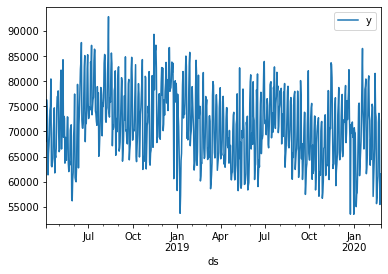

In [ ]:
agg_glb.set_index('ds').plot()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import StrMethodFormatter

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 18

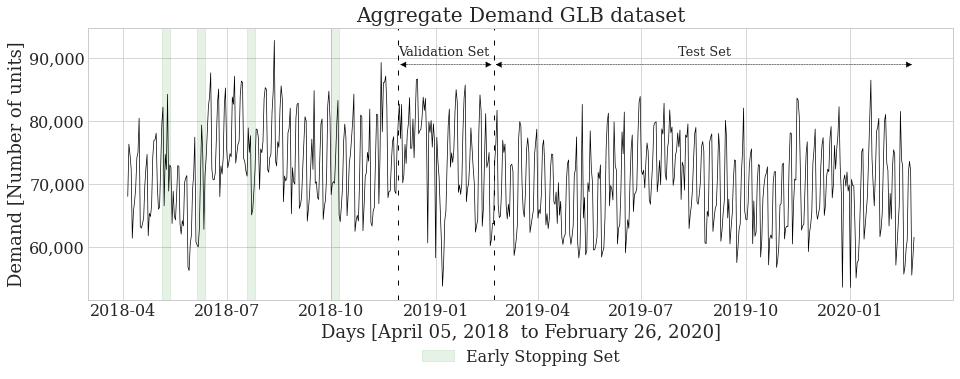

In [ ]:
fig = plt.figure(figsize=(15.5, 5))

fig.tight_layout()
y_min = 50_000
y_max = 2 * y_min
plt.ylim(y_min, y_max)
ax0 = plt.subplot2grid((1,1),(0, 0))
axs = [ax0]

title_str  = 'Aggregate Demand GLB dataset'
y_axis_str = f'Demand [Number of units]'

x_plot = agg_glb.ds.values
x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y') #'%B %d, %Y, %r'
x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y') #'%B %d, %Y, %r'

np.random.seed(6)
early_stopping_ds = np.random.choice(x_plot[:-7 * 54], 4, replace=False)
early_stopping_ds = [(es_ds, es_ds + pd.Timedelta(days=7)) for es_ds in early_stopping_ds]

x_axis_str = f'Days [{x_plot_min}  to {x_plot_max}]'

y_plot = agg_glb.y.values

axs[0].plot(x_plot, y_plot, color='black', linewidth=0.7)
axs[0].tick_params(labelsize=FONTSIZE-2)
axs[0].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[0].set_ylabel(y_axis_str, fontsize=FONTSIZE)
axs[0].set_title(title_str, fontsize = FONTSIZE + 2)
axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

for i, inter in enumerate(early_stopping_ds):
    axs[0].axvspan(*inter, alpha=0.1, color='green',
                   label =  "_"*i + "Early Stopping Set")

#axs[0].axvspan(8, 14, alpha=0.5, color='red')

init_val = x_plot[-7 * (53 + 12)]
init_test = x_plot[-7 * 53]

axs[0].axvline(init_val, 
               linestyle=(0, (5, 10)), 
               color='black', 
               linewidth=1.)
axs[0].axvline(init_test,  
               linestyle=(0, (5, 10)), 
               color='black', 
               linewidth=1.)

axs[0].annotate('',
                xy=(init_test, 89_000), 
                xycoords='data',
                xytext=(init_val, 89_000), 
                textcoords='data', 
                fontsize = FONTSIZE - 5,
                arrowprops=dict(arrowstyle='<|-|>', color='black', 
                                linestyle='--',
                                linewidth=0.5), 
                verticalalignment='bottom')

axs[0].annotate('Validation Set',
                xy=(init_test, 90_000), 
                xycoords='data',
                xytext=(init_val, 90_000), 
                textcoords='data', 
                fontsize = FONTSIZE - 5, 
                verticalalignment='bottom')

axs[0].annotate('',
                xy=(x_plot[-1], 89_000), 
                xycoords='data',
                xytext=(init_test, 89_000), 
                textcoords='data', 
                fontsize = FONTSIZE - 5,
                arrowprops=dict(arrowstyle='<|-|>', color='black', 
                                linestyle='--',
                                linewidth=0.5), 
                verticalalignment='bottom')

axs[0].annotate('Test Set',
                xy=(x_plot[-1], 90_000), 
                xycoords='data',
                xytext=(init_test + pd.Timedelta(days=53 * 7 / 2), 90_000), 
                textcoords='data', 
                fontsize = FONTSIZE - 5,
                verticalalignment='bottom',
                horizontalalignment='center')

axs[0].legend(loc='center', bbox_to_anchor=(.5, -0.21), prop={'size': FONTSIZE - 2})
plt.savefig('../results/business/train_methodology.pdf', bbox_inches = 'tight')
plt.show()